In [1]:
import pandas as pd 
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal 
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
col_names = ["SepalLengthCm",  "SepalWidthCm", "PetalLengthCm","PetalWidthCm", "Class"]
iris = pd.read_csv('iris.data', names = col_names)

df = iris.iloc[:,0:4]
y = iris.iloc[:,-1]
data = iris.iloc[:,:-1].values

In [3]:
data[0]

array([5.1, 3.5, 1.4, 0.2])

In [4]:
#number of data
n = len(df)

#number of clusters
k = 3

#dimension of cluster
d = 4

# fuzziness - m parameter
m = 2

#number of iterations
MAX_ITERS = 2

In [5]:
def initializeMembershipWeights():
    membership_mat = []
    np.random.seed(0) #Code B
    for i in range(n):
        wts = []
        sum=0;
        for j in range(k):
            weight = np.random.random_integers(1,10)
            wts.append(weight)
            sum = sum + weight
        weights = [w/sum for w in wts]
        membership_mat.append(weights)
    return np.array(membership_mat)

In [6]:
def computeCentroids(weight_arr):
    C = []
    for i in range(k):
        weight_sum = np.power(weight_arr[:,i],m).sum()
        Cj = []
        for x in range(d):
            numerator = ( df.iloc[:,x].values).sum()
            c_val = numerator/weight_sum;
            Cj.append(c_val)
        C.append(Cj)
    return C 

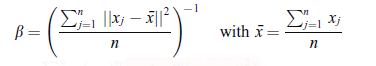

In [7]:
# Another way to calculate Beta.. Using simple for loops
def betaG():
    mean_vector = []
    for dimension in range(d):
        columnSum = 0.0
        for dataPoint in range(n):
            columnSum += data[dataPoint][dimension]
        mean_vector.append(columnSum/n)
        
    total_sum = 0.0
#     beta = 0
    for dataPoint in range(n):
#         total_sum = 0.0
        for dimension in range(d):
            total_sum += np.sqrt(np.power(data[dataPoint][dimension] - mean_vector[dimension], 2))
#         beta += (n/total_sum)  # Shall I use this one ? 
#     beta = np.power(np.divide(total_sum, n), -1)
    beta = n/total_sum   #Or Shall I use this one? 
    return beta

In [8]:
betaG()

0.30849894013475265

In [9]:
def euclidean_dis(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

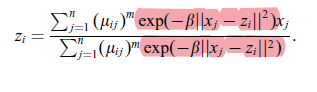

In [10]:
def computeAFCMCentroids(weight_arr, Centroids, data):
    C = []
    beta = betaG()
    uij = []
    
    #Calculation of uij row by row
    for dataPoint in range(len(data)):
        uij_row = []
        for cluster in range(k):
            uij_row.append(np.power(weight_arr[dataPoint][cluster], m))
        uij.append(uij_row)
        
    cluster_center = []
    for cluster in range(k):
        centroid_row = []
        for diamention in range(d):
            numerator = 0.0
            denominator = 0.0
            for dataPoint in range(n):
                distance = 1 / (np.exp(-beta * euclidean_dis(data[dataPoint], Centroids[cluster])));
                
                numerator += uij[dataPoint][cluster] * data[dataPoint][diamention] * distance;
                denominator += uij[dataPoint][cluster] * distance;
            centroid_row.append(np.divide(numerator, denominator))
        cluster_center.append(centroid_row)
    return cluster_center

In [11]:
# weight_arr = initializeMembershipWeights()
# C = computeCentroids(weight_arr)
# Centroids = computeAFCMCentroids(weight_arr, C, data)

In [12]:
# Centroids

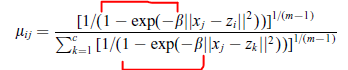

### Another way to calculate weight matrix

In [13]:
def get_norm(i, j, centroids):
    sum = 0.0
    for k in range(d):
        sum += np.power(data[i][k] - centroids[j][k], 2)
    return np.sqrt(sum)

In [14]:
def get_new_value(i, j, centroids):
    beta = betaG()
    sum = 0.0
    p = 1 / (m - 1)
    for cluster in range(k):
        t = 1/ (1-np.exp(-beta * np.power(get_norm(i, cluster, centroids), 2)))
        t = pow(t, p)
        sum += t
    
    numerator = 1 /(1 - np.exp(-beta*np.power(get_norm(i,j, centroids), 2)))
    return numerator/sum

In [15]:
def update_degree_of_membership(weight_arr, centroids):
    
    new_uij = []
    max_diff = 0.0
    for cluster in range(k):
        for dataPoint in range(n):
            new_uij = get_new_value(dataPoint, cluster, centroids)
            diff = new_uij - weight_arr[dataPoint][cluster]
            weight_arr[dataPoint][cluster] = new_uij;

    return weight_arr

In [16]:
# update_degree_of_membership(weight_arr)

In [17]:
def plotData(z,C):  
    plt.subplot(4,3,z+1)              #scatter plot of Petal length vs Petal width                              
    plt.scatter(list(df.iloc[:,2]), list(df.iloc[:,3]), marker='o')    
    for center in C:
        plt.scatter(center[2],center[3], marker='o',color='r')        
    plt.axis('equal')                                                                 
    plt.xlabel('Petal Length', fontsize=18)                                                 
    plt.ylabel('Petal Width', fontsize=18)                                                                                      
    plt.grid() 

In [18]:
def getClusters(membership_mat): # getting the clusters
    cluster_labels = []
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

In [19]:
# If only iterating for 2 times then it will give 80% accuracy. But I increase the iteration, accuracy is getting lower.
# Why it is not working with maximum iterations? 

def FuzzyMeansAlgorithm():
    weight_arr = initializeMembershipWeights()
    C = computeCentroids(weight_arr)
    C = computeAFCMCentroids(weight_arr, C, data)
    
    acc=[]
    for z in range(MAX_ITERS):
#         centroids = computeAFCMCentroids(weight_arr, C, data)
        weight_arr = update_degree_of_membership(weight_arr, C)
        C = computeAFCMCentroids(weight_arr, C, data)
        
        cluster_labels = getClusters(weight_arr)
        acc.append(cluster_labels)
    return (weight_arr, C, acc, cluster_labels)

In [20]:
final_weights, Centers, acc, labels = FuzzyMeansAlgorithm()

## Calculating Accuracy

In [21]:
def accuracy(cluster_labels, class_labels):
    correct_pred = 0
    seto = max(set(labels[0:50]), key=labels[0:50].count)
    vers = max(set(labels[50:100]), key=labels[50:100].count)
    virg = max(set(labels[100:]), key=labels[100:].count)
    
    for i in range(len(df)):
        if cluster_labels[i] == seto and class_labels[i] == 'Iris-setosa':
            correct_pred = correct_pred + 1
        if cluster_labels[i] == vers and class_labels[i] == 'Iris-versicolor' and vers!=seto:
            correct_pred = correct_pred + 1
        if cluster_labels[i] == virg and class_labels[i] == 'Iris-virginica' and virg!=seto and virg!=vers:
            correct_pred = correct_pred + 1
            
    accuracy = (correct_pred/len(df))*100
    return accuracy

In [22]:
acc_lis = [] 
for i in range(len(acc)):
    val = accuracy(acc[i], y)
    acc_lis.append(val)

In [23]:
print("Accuracy => ", max(acc_lis))

Accuracy =>  80.0
